# Preset

In [1]:
!pip install boto3

# Download dataset from Kaggle

In [2]:
import zipfile
from google.colab import files

In [3]:
# Upload your kaggle api token
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"yosait","key":"421c039b3b5e7f009cf78dc02b1a4764"}'}

In [4]:
# Download formula 1 dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rohanrao/formula-1-world-championship-1950-2020

formula-1-world-championship-1950-2020.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# Unzip
with zipfile.ZipFile("formula-1-world-championship-1950-2020.zip", "r") as zip_ref:
    zip_ref.extractall("data")

# Read downloaded csv

In [6]:
from datetime import timedelta
from pathlib import Path

import numpy as np
import pandas as pd

In [7]:
dir = Path("data")

df_qualifying = pd.read_csv(dir / "qualifying.csv")
df_results = pd.read_csv(dir / "results.csv")
df_races = pd.read_csv(dir / "races.csv")
df_drivers = pd.read_csv(dir / "drivers.csv")
df_constructors = pd.read_csv(dir / "constructors.csv")

In [8]:
df_qualifying.drop(columns=["number"], inplace=True)
df_results.drop(columns=["number"], inplace=True)
df_drivers.drop(columns=["number"], inplace=True)

df = pd.merge(df_results, df_qualifying, on=["raceId", "driverId", "constructorId"], how="left", suffixes=["_race", "_qualify"])
df = pd.merge(df, df_races.loc[:, ["raceId", "year", "round", "circuitId", "name", "date"]], on="raceId", how="left")
df = pd.merge(df, df_drivers.loc[:, ["driverId", "driverRef"]], on="driverId", how="left")
df = pd.merge(df, df_constructors.loc[:, ["constructorId", "constructorRef"]], on="constructorId", how="left")

df.drop(columns=["points", "grid", "resultId", "raceId", "driverId", "position_qualify", "constructorId", "circuitId", "statusId", "qualifyId", "fastestLap", "fastestLapSpeed", "fastestLapTime", "time", "positionText", "position_race", "date", "rank","laps"], inplace=True)

df.replace({"\\N": np.nan}, inplace=True)
df.reset_index(drop=True, inplace=True)
df.rename(
    columns={
        "name": "grandprix",
        "positionOrder": "position",
        "driverRef": "driver",
        "constructorRef": "constructor"

    },
    inplace=True
)

In [9]:
# Format time related columns to sec for comparison to ergast_py

def cvt_qualifytime_to_sec(str_time):
    """Convert string as a format of minute:second.millsecond to sec"""
    try:
        minutes, seconds = str_time.split(":")
        seconds, milliseconds = seconds.split(".")
        time = timedelta(minutes=int(minutes), seconds=int(seconds), milliseconds=int(milliseconds))
        return time.total_seconds()
    except:
        return np.nan

for qualify_round in range(1, 4):
    df[f"q{qualify_round}_sec"] = df[f"q{qualify_round}"].apply(cvt_qualifytime_to_sec)
df["race_sec"] = df["milliseconds"].astype(float) / 1000

df.drop(columns=["milliseconds", "q1", "q2", "q3"], inplace=True)

In [10]:
# If you can create table like format below, you can predict race results with pretrained model that will be created by this notebook
df.loc[(df["year"]==2022)&(df["round"]==22)]

,position,year,round,grandprix,driver,constructor,q1_sec,q2_sec,q3_sec,race_sec
25820,1,2022,22,Abu Dhabi Grand Prix,max_verstappen,red_bull,84.754,84.622,83.824,5265.914
25821,2,2022,22,Abu Dhabi Grand Prix,leclerc,ferrari,85.211,84.517,84.092,5274.685
25822,3,2022,22,Abu Dhabi Grand Prix,perez,red_bull,84.820,84.419,84.052,5276.007
25823,4,2022,22,Abu Dhabi Grand Prix,sainz,ferrari,85.090,84.521,84.242,5290.806
25824,5,2022,22,Abu Dhabi Grand Prix,russell,mercedes,85.545,84.940,84.511,5301.802
25825,6,2022,22,Abu Dhabi Grand Prix,norris,mclaren,85.387,84.903,84.769,5322.148
25826,7,2022,22,Abu Dhabi Grand Prix,ocon,alpine,85.735,85.007,84.830,5323.154
25827,8,2022,22,Abu Dhabi Grand Prix,stroll,aston_martin,85.741,85.359,NaN,5342.845
25828,9,2022,22,Abu Dhabi Grand Prix,ricciardo,mclaren,85.766,85.068,85.045,5349.182
25829,10,2022,22,Abu Dhabi Grand Prix,vettel,aston_martin,85.523,84.974,84.961,5349.812


# Preprocess
- The process below should be the same as preprocess of inference

In [11]:
from tqdm import tqdm

In [12]:
# Before shift and rolling

def create_data(df):
    """Create processed data"""
    list_df = []
    for year in tqdm(df["year"].unique()):
        df_season = df.loc[df["year"]==year].copy()
        for round in df_season["round"].unique():
            df_round = df_season.loc[df_season["round"]==round].copy()

            list_prev_position = []
            for driver, gp in zip(df_round["driver"], df_round["grandprix"]):
                df_round_driver_prev = df.loc[(df["year"]==year - 1)&(df["driver"]==driver)&(df["grandprix"]==gp)]
                if len(df_round_driver_prev) > 0:
                    prev_position = df_round_driver_prev["position"].values[0]
                else:
                    prev_position = np.nan
                list_prev_position.append(prev_position)
            df_round["prev_position"] = list_prev_position

            slowest_q1 = df_round['q1_sec'].dropna().max()
            slowest_q2 = df_round['q2_sec'].dropna().max()
            slowest_q3 = df_round['q3_sec'].dropna().max()
            fillvalue_q1 = slowest_q1 * 1.08
            fillvalue_q2 = slowest_q2 * 1.08
            fillvalue_q3 = slowest_q3 * 1.08
            df_round['q1_sec'].fillna(fillvalue_q1, inplace=True)
            df_round['q2_sec'].fillna(fillvalue_q2, inplace=True)
            df_round['q3_sec'].fillna(fillvalue_q3, inplace=True)

            fastest_q1 = df_round["q1_sec"].min()
            fastest_q2 = df_round["q2_sec"].min()
            fastest_q3 = df_round["q3_sec"].min()
            fastest_race = df_round["race_sec"].min()

            df_round["q1_percent"] = ((df_round["q1_sec"] - fastest_q1) / fastest_q1) * 100
            df_round["q2_percent"] = ((df_round["q2_sec"] - fastest_q2) / fastest_q2) * 100
            df_round["q3_percent"] = ((df_round["q3_sec"] - fastest_q3) / fastest_q3) * 100
            df_round["race_diff_sec"] = df_round["race_sec"] - fastest_race
            df_round_constructor = df_round.groupby("constructor")[["position", "q1_percent", "q2_percent", "q3_percent", "race_diff_sec"]].mean().reset_index()
            df_round = pd.merge(df_round, df_round_constructor, on="constructor", how="left", suffixes=["", "_constructor"])

            list_df.append(df_round)

    df_processed = pd.concat(list_df)
    df_processed.drop(columns=["q1_sec", "q2_sec", "q3_sec", "race_sec"], inplace=True)

    return df_processed

In [13]:
df_processed = create_data(df)

100%|██████████| 73/73 [03:03<00:00,  2.52s/it]


In [14]:
df_processed.loc[(df_processed["year"]==2022)&(df_processed["round"]==22)]

,position,year,round,grandprix,driver,constructor,prev_position,q1_percent,q2_percent,q3_percent,race_diff_sec,position_constructor,q1_percent_constructor,q2_percent_constructor,q3_percent_constructor,race_diff_sec_constructor
0,1,2022,22,Abu Dhabi Grand Prix,max_verstappen,red_bull,1.0,0.000000,0.240467,0.000000,0.000,2.0,0.038936,0.120234,0.135999,5.0465
1,2,2022,22,Abu Dhabi Grand Prix,leclerc,ferrari,10.0,0.539208,0.116088,0.319718,8.771,3.0,0.467825,0.118457,0.409191,16.8315
2,3,2022,22,Abu Dhabi Grand Prix,perez,red_bull,15.0,0.077872,0.000000,0.271998,10.093,2.0,0.038936,0.120234,0.135999,5.0465
3,4,2022,22,Abu Dhabi Grand Prix,sainz,ferrari,3.0,0.396441,0.120826,0.498664,24.892,3.0,0.467825,0.118457,0.409191,16.8315
4,5,2022,22,Abu Dhabi Grand Prix,russell,mercedes,18.0,0.933289,0.617160,0.819574,35.888,11.5,0.962196,0.518841,0.817785,35.8880
5,6,2022,22,Abu Dhabi Grand Prix,norris,mclaren,7.0,0.746867,0.573331,1.127362,56.234,7.5,0.970456,0.671057,1.291993,69.7510
6,7,2022,22,Abu Dhabi Grand Prix,ocon,alpine,9.0,1.157467,0.696526,1.200134,57.240,13.5,1.185195,0.749239,5.386643,57.2400
7,8,2022,22,Abu Dhabi Grand Prix,stroll,aston_martin,13.0,1.164547,1.113493,9.573153,76.931,9.0,1.035939,0.885464,5.464783,80.4145
8,9,2022,22,Abu Dhabi Grand Prix,ricciardo,mclaren,12.0,1.194044,0.768784,1.456623,83.268,7.5,0.970456,0.671057,1.291993,69.7510
9,10,2022,22,Abu Dhabi Grand Prix,vettel,aston_martin,11.0,0.907332,0.657435,1.356413,83.898,9.0,1.035939,0.885464,5.464783,80.4145


# Create features
- The process below should be the same as preprocess of inference

In [15]:
from collections import defaultdict

In [16]:
list_col_X = [
    "recent_position",
    "recent_race_diff_sec",
    "recent_q1_percent",
    "recent_q2_percent",
    "recent_q3_percent",
    "recent_position_std",
    "recent_race_diff_sec_std",
    "recent_q1_percent_std",
    "recent_q2_percent_std",
    "recent_q3_percent_std",
    "season_position",
    "season_race_diff_sec",
    "season_q1_percent",
    "season_q2_percent",
    "season_q3_percent",
    "recent_position_constructor",
    "recent_race_diff_sec_constructor",
    "recent_q1_percent_constructor",
    "recent_q2_percent_constructor",
    "recent_q3_percent_constructor",
    "recent_position_std_constructor",
    "recent_race_diff_sec_std_constructor",
    "recent_q1_percent_std_constructor",
    "recent_q2_percent_std_constructor",
    "recent_q3_percent_std_constructor",
    "season_position_constructor",
    "season_race_diff_sec_constructor",
    "season_q1_percent_constructor",
    "season_q2_percent_constructor",
    "season_q3_percent_constructor",
    "prev_position",
    "round",
]

list_col_y = ["y"]

list_col_identifier = ["year", "driver", "constructor", "grandprix"]


def create_features(df):
    """Create features"""
    dict_features = {x: [] for x in list_col_X + list_col_y + list_col_identifier}

    for year in tqdm(df["year"].unique()):
        df_season = df.loc[df["year"]==year].copy()
        for driver in df_season["driver"].unique():
            df_driver = df_season.loc[df_season["driver"]==driver].copy().sort_values(by="round").reset_index(drop=True)
            df_driver.set_index('round', inplace=True)

            dict_features["recent_position"] += list(df_driver['position'].shift().rolling(window=3, min_periods=1).apply(np.nanmean, raw=True))
            dict_features["recent_race_diff_sec"] += list(df_driver['race_diff_sec'].shift().rolling(window=3, min_periods=1).apply(np.nanmean, raw=True))
            dict_features["recent_q1_percent"] += list(df_driver['q1_percent'].shift().rolling(window=3, min_periods=1).apply(np.nanmean, raw=True))
            dict_features["recent_q2_percent"] += list(df_driver['q2_percent'].shift().rolling(window=3, min_periods=1).apply(np.nanmean, raw=True))
            dict_features["recent_q3_percent"] += list(df_driver['q3_percent'].shift().rolling(window=3, min_periods=1).apply(np.nanmean, raw=True))
            dict_features["recent_position_std"] += list(df_driver['position'].shift().rolling(window=3, min_periods=1).apply(np.nanstd, raw=True))
            dict_features["recent_race_diff_sec_std"] += list(df_driver['race_diff_sec'].shift().rolling(window=3, min_periods=1).apply(np.nanstd, raw=True))
            dict_features["recent_q1_percent_std"] += list(df_driver['q1_percent'].shift().rolling(window=3, min_periods=1).apply(np.nanstd, raw=True))
            dict_features["recent_q2_percent_std"] += list(df_driver['q2_percent'].shift().rolling(window=3, min_periods=1).apply(np.nanstd, raw=True))
            dict_features["recent_q3_percent_std"] += list(df_driver['q3_percent'].shift().rolling(window=3, min_periods=1).apply(np.nanstd, raw=True))
            dict_features["season_position"] += list(df_driver['position'].shift().rolling(window=df_season["round"].max(), min_periods=1).apply(np.nanmean, raw=True))
            dict_features["season_race_diff_sec"] += list(df_driver['race_diff_sec'].shift().rolling(window=df_season["round"].max(), min_periods=1).apply(np.nanmean, raw=True))
            dict_features["season_q1_percent"] += list(df_driver['q1_percent'].shift().rolling(window=df_season["round"].max(), min_periods=1).apply(np.nanmean, raw=True))
            dict_features["season_q2_percent"] += list(df_driver['q2_percent'].shift().rolling(window=df_season["round"].max(), min_periods=1).apply(np.nanmean, raw=True))
            dict_features["season_q3_percent"] += list(df_driver['q3_percent'].shift().rolling(window=df_season["round"].max(), min_periods=1).apply(np.nanmean, raw=True))

            dict_features["recent_position_constructor"] += list(df_driver['position_constructor'].shift().rolling(window=3, min_periods=1).apply(np.nanmean, raw=True))
            dict_features["recent_race_diff_sec_constructor"] += list(df_driver['race_diff_sec_constructor'].shift().rolling(window=3, min_periods=1).apply(np.nanmean, raw=True))
            dict_features["recent_q1_percent_constructor"] += list(df_driver['q1_percent_constructor'].shift().rolling(window=3, min_periods=1).apply(np.nanmean, raw=True))
            dict_features["recent_q2_percent_constructor"] += list(df_driver['q2_percent_constructor'].shift().rolling(window=3, min_periods=1).apply(np.nanmean, raw=True))
            dict_features["recent_q3_percent_constructor"] += list(df_driver['q3_percent_constructor'].shift().rolling(window=3, min_periods=1).apply(np.nanmean, raw=True))
            dict_features["recent_position_std_constructor"] += list(df_driver['position_constructor'].shift().rolling(window=3, min_periods=1).apply(np.nanstd, raw=True))
            dict_features["recent_race_diff_sec_std_constructor"] += list(df_driver['race_diff_sec_constructor'].shift().rolling(window=3, min_periods=1).apply(np.nanstd, raw=True))
            dict_features["recent_q1_percent_std_constructor"] += list(df_driver['q1_percent_constructor'].shift().rolling(window=3, min_periods=1).apply(np.nanstd, raw=True))
            dict_features["recent_q2_percent_std_constructor"] += list(df_driver['q2_percent_constructor'].shift().rolling(window=3, min_periods=1).apply(np.nanstd, raw=True))
            dict_features["recent_q3_percent_std_constructor"] += list(df_driver['q3_percent_constructor'].shift().rolling(window=3, min_periods=1).apply(np.nanstd, raw=True))
            dict_features["season_position_constructor"] += list(df_driver['position_constructor'].shift().rolling(window=df_season["round"].max(), min_periods=1).apply(np.nanmean, raw=True))
            dict_features["season_race_diff_sec_constructor"] += list(df_driver['race_diff_sec_constructor'].shift().rolling(window=df_season["round"].max(), min_periods=1).apply(np.nanmean, raw=True))
            dict_features["season_q1_percent_constructor"] += list(df_driver['q1_percent_constructor'].shift().rolling(window=df_season["round"].max(), min_periods=1).apply(np.nanmean, raw=True))
            dict_features["season_q2_percent_constructor"] += list(df_driver['q2_percent_constructor'].shift().rolling(window=df_season["round"].max(), min_periods=1).apply(np.nanmean, raw=True))
            dict_features["season_q3_percent_constructor"] += list(df_driver['q3_percent_constructor'].shift().rolling(window=df_season["round"].max(), min_periods=1).apply(np.nanmean, raw=True))

            dict_features["prev_position"] += list(df_driver["prev_position"])
            dict_features["year"] += list(df_driver["year"])
            dict_features["round"] += list(df_driver.index)
            dict_features["driver"] += list(df_driver["driver"])
            dict_features["constructor"] += list(df_driver["constructor"])
            dict_features["grandprix"] += list(df_driver["grandprix"])
            dict_features["y"] += list(df_driver["position"])

    df_features = pd.DataFrame(dict_features)

    return df_features


In [17]:
df_features = create_features(df_processed)

100%|██████████| 73/73 [01:34<00:00,  1.29s/it]


In [18]:
df_features.loc[(df_features["year"]==2022)&(df_features["round"]==2)]

,recent_position,recent_race_diff_sec,recent_q1_percent,recent_q2_percent,recent_q3_percent,recent_position_std,recent_race_diff_sec_std,recent_q1_percent_std,recent_q2_percent_std,recent_q3_percent_std,...,season_q1_percent_constructor,season_q2_percent_constructor,season_q3_percent_constructor,prev_position,round,y,year,driver,constructor,grandprix
25401,1.0,0.000,0.000000,0.192823,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.052476,0.112939,0.071225,7.0,2,2,2022,leclerc,ferrari,Saudi Arabian Grand Prix
25423,2.0,5.598,0.104951,0.033055,0.142450,0.0,0.0,0.0,0.0,0.0,...,0.052476,0.112939,0.071225,8.0,2,3,2022,sainz,ferrari,Saudi Arabian Grand Prix
25445,3.0,9.675,0.889900,0.320636,0.750900,0.0,0.0,0.0,0.0,0.0,...,0.881154,0.433024,1.290885,1.0,2,10,2022,hamilton,mercedes,Saudi Arabian Grand Prix
25467,4.0,11.211,0.872408,0.545412,1.830871,0.0,0.0,0.0,0.0,0.0,...,0.881154,0.433024,1.290885,19.0,2,5,2022,russell,mercedes,Saudi Arabian Grand Prix
25489,5.0,14.754,0.529129,0.775698,1.380331,0.0,0.0,0.0,0.0,0.0,...,0.761444,1.071543,5.751585,NaN,2,9,2022,kevin_magnussen,haas,Saudi Arabian Grand Prix
25511,6.0,16.119,0.489773,1.057770,1.106473,0.0,0.0,0.0,0.0,0.0,...,0.803533,2.063753,5.614656,3.0,2,15,2022,bottas,alfa,Saudi Arabian Grand Prix
25533,7.0,19.423,0.623148,1.129389,10.122838,0.0,0.0,0.0,0.0,0.0,...,0.789868,1.040691,5.965260,4.0,2,6,2022,ocon,alpine,Saudi Arabian Grand Prix
25555,8.0,20.386,1.398257,11.315315,10.122838,0.0,0.0,0.0,0.0,0.0,...,1.040767,6.141367,6.044215,14.0,2,19,2022,tsunoda,alphatauri,Saudi Arabian Grand Prix
25577,9.0,22.390,0.956587,0.951993,1.807681,0.0,0.0,0.0,0.0,0.0,...,0.789868,1.040691,5.965260,13.0,2,16,2022,alonso,alpine,Saudi Arabian Grand Prix
25599,10.0,23.064,1.117294,3.069736,10.122838,0.0,0.0,0.0,0.0,0.0,...,0.803533,2.063753,5.614656,NaN,2,11,2022,zhou,alfa,Saudi Arabian Grand Prix


# Create model
- Split dataset for train and test
- Train regressor model and classifier model

In [19]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier

In [20]:
callbacks = [lgb.early_stopping(20, verbose=1), lgb.log_evaluation(period=0)]

def train_model(df_features, list_col_X, test_size=0.2, model_type="classifier", early_stopping_rounds=10):
    """Train model"""
    X = df_features.loc[:, list_col_X].copy()

    if model_type == "classifier":
        y = df_features["y"] == 1
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

        num_negatives = sum(y_train == 0)
        num_positives = sum(y_train == 1)
        scale_pos_weight = num_negatives / num_positives

        model = LGBMClassifier(
            objective='binary',
            n_estimators=1000,
            metric="binary_logloss", #use binary_logloss instead of auc in order to use output as probabilty to win the race
            # scale_pos_weight=scale_pos_weight,
            class_weight='balanced'
        )

        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=callbacks)
    else:
        y = df_features["y"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        model = LGBMRegressor(n_estimators=1000)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=callbacks)
    return model, X_test, y_test


def predict(model, X, model_type="classifier"):
    """Predict"""
    if model_type == "classifier":
        return model.predict_proba(X)[:, 1]
    else:
        return model.predict(X)

In [21]:
model_classifier, X_test_classifier, y_test_classifier = train_model(df_features, list_col_X, model_type="classifier")

[LightGBM] [Info] Number of positive: 864, number of negative: 19808
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7525
[LightGBM] [Info] Number of data points in the train set: 20672, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[331]	valid_0's binary_logloss: 0.208638


In [22]:
model_regressor, X_test_regressor, y_test_regressor = train_model(df_features, list_col_X, model_type="regressor")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7525
[LightGBM] [Info] Number of data points in the train set: 20672, number of used features: 32
[LightGBM] [Info] Start training from score 12.847717
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's l2: 41.4983


In [23]:
y_pred_classifier = predict(model_classifier, X_test_classifier, model_type="classifier")
y_pred_regressor = predict(model_regressor, X_test_regressor, model_type="regressor")

# Evaluate
- Adhoc check of trained models

In [24]:
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error, roc_curve, auc, precision_recall_curve, confusion_matrix

In [25]:
def plot_feature_importance(model):
    feature_importances = model.feature_importances_

    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=100)
    plt.title("Feature importances")
    plt.show()

In [26]:
print(roc_auc_score(y_test_classifier, y_pred_classifier))

0.831889537577611


In [27]:
print(mean_squared_error(y_test_regressor, y_pred_regressor))
print(mean_absolute_error(y_test_regressor, y_pred_regressor))

41.498254002265476
5.326467302446692


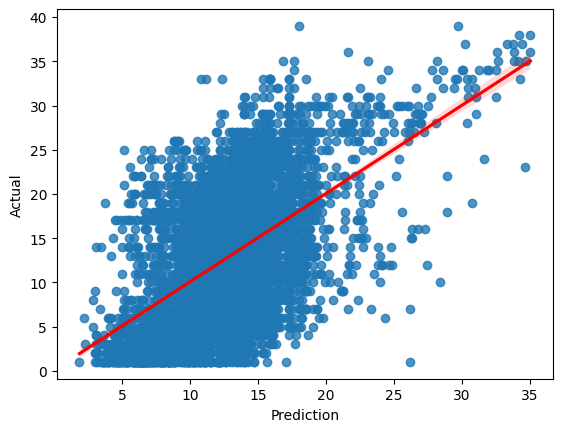

In [28]:
sns.regplot(y=y_test_regressor, x=y_pred_regressor, line_kws={"color": "red"})
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

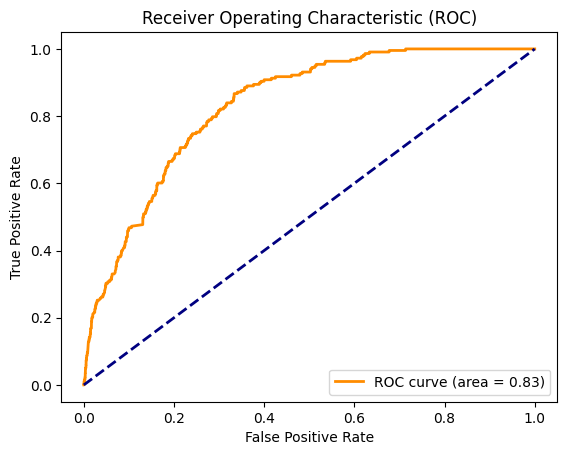

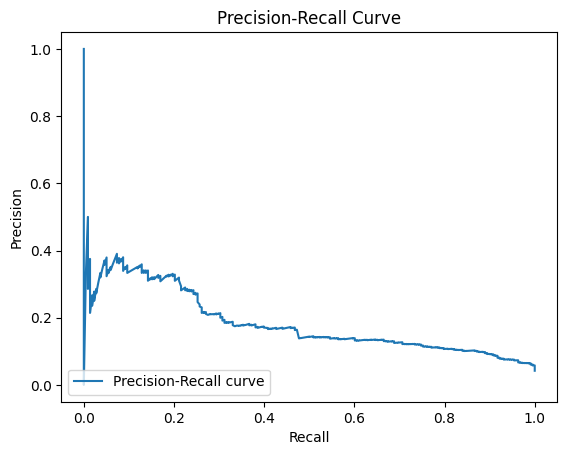

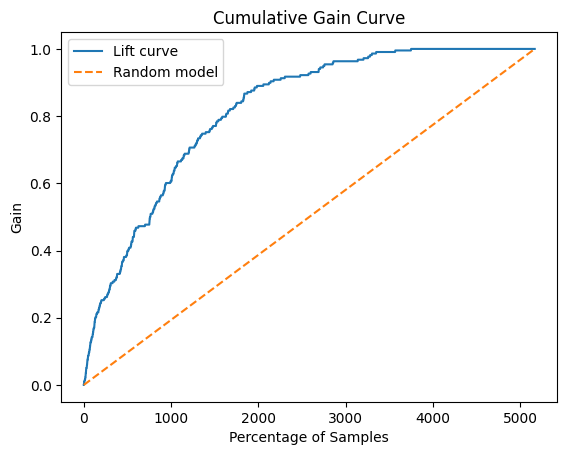

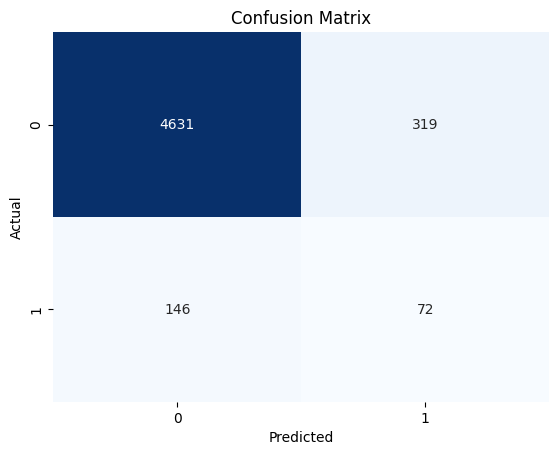

In [29]:
# Area Under the Curve
fpr, tpr, thresholds = roc_curve(y_test_classifier, y_pred_classifier)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


# Precision Recall Curve
precision, recall, _ = precision_recall_curve(y_test_classifier, y_pred_classifier)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Cumulative Gain Curve
sorted_indices = np.argsort(y_pred_classifier)[::-1]
y_test_sorted = np.array(y_test_classifier)[sorted_indices]

cumulative_gains = np.cumsum(y_test_sorted) / np.sum(y_test_sorted)
random_model = np.linspace(0, 1, len(y_test_classifier))

plt.figure()
plt.plot(cumulative_gains, label='Lift curve')
plt.plot(random_model, linestyle='--', label='Random model')
plt.xlabel('Percentage of Samples')
plt.ylabel('Gain')
plt.title('Cumulative Gain Curve')
plt.legend(loc="upper left")
plt.show()

# Confusion Matrix
matrix = confusion_matrix(y_test_classifier, np.round(y_pred_classifier))

plt.figure()
sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<Figure size 1000x800 with 0 Axes>

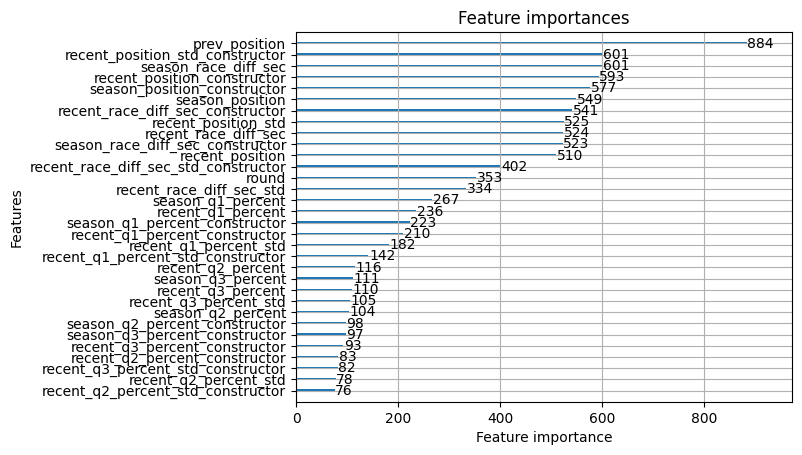

In [30]:
plot_feature_importance(model_classifier)

<Figure size 1000x800 with 0 Axes>

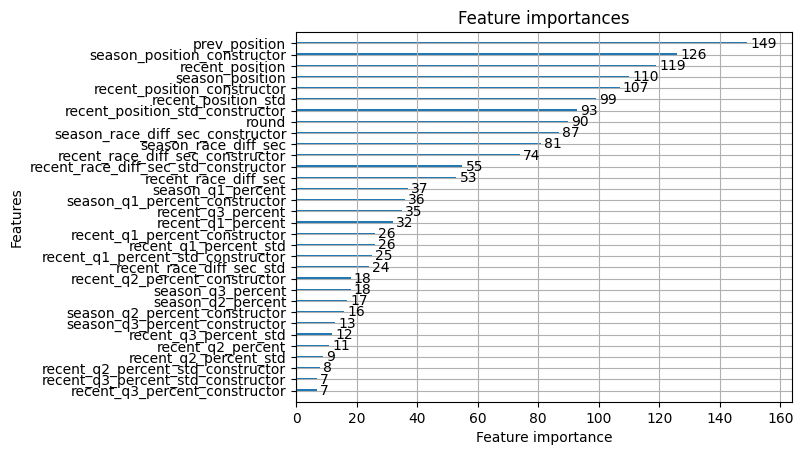

In [31]:
plot_feature_importance(model_regressor)

# Save model to S3

In [32]:
import pickle
import boto3

In [33]:
AWS_ACCESS_KEY_ID = 'YOUR_AWS_ACCESS_KEY'
AWS_SECRET_ACCESS_KEY = 'YOUR_AWS_SECRET_KEY'
BUCKET_NAME = 'YOUR_BUCKET_NAME'
OBJECT_NAME = 'model.pkl'

In [37]:
# Use classification model
with open('model.pkl', 'wb') as f:
    pickle.dump(model_classifier, f)

s3 = boto3.client("s3", aws_access_key_id=AWS_ACCESS_KEY_ID, aws_secret_access_key=AWS_SECRET_ACCESS_KEY)
s3.upload_file("model.pkl", BUCKET_NAME, OBJECT_NAME)